# Kunskapskontroll 2, MNIST
## Cyritha Ljungberg

Jag börjar med att importera samtliga bibliotek jag behöver för uppgiften. Sedan laddar jag in datasetet.

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.ensemble import RandomForestClassifier

In [2]:
mnist = fetch_openml("mnist_784", version=1, as_frame=False)   # cashe = True
print(mnist.DESCR)

# Instruktionen i uppgiften är skriven med cache= för fetch_openml
# Detta argument stöds inte i min version, därför utelämnas det

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

MNIST är ett dataset med handskrivna siffror (0–9). Varje bild är 28×28 pixlar och representeras som 784 numeriska features.

## Nu vill jag undersöka datan, EDA.

In [3]:
# Först ser jag vilka delar/nycklar datasetet består av
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
# Undersöker datasetet

X = mnist["data"]    # features/input
y = mnist["target"]  #  labels/det vi vill förutsäga

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Alltså består datasetet av 70 000 bilder, 784 features (i detta fall pixlar) per bild och 70 000 labels.

In [5]:
print(type(X))
print(type(y))
print(type(y[0]))   # kontrollera först vilken datatyp y är

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'str'>


In [6]:
y = y.astype(int)   # konverterar till int

print(type(y[0]))   # kontrollerar  igen

# Target-variabeln levereras som strängar och konverteras därför till heltal innan modellträning


<class 'numpy.int64'>


Skapar en DataFrame för att kunna använda .head() för att underlätta EDA

In [7]:
df = pd.DataFrame(X)
df["target"] = y

df.head()

# Får fram pixelpositioner


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


Identifierar eventuella null-värden och ser på antal rader, datatyper och minne

In [8]:
df.isnull().sum()

0         0
1         0
2         0
3         0
4         0
         ..
780       0
781       0
782       0
783       0
target    0
Length: 785, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 785 entries, 0 to target
dtypes: int64(785)
memory usage: 419.2 MB


In [10]:
df["target"].value_counts().sort_index()


target
0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
Name: count, dtype: int64

### Detta MNIST-dataset innehåller inga nullvärden och alla pixelkolumner är numeriska.
Jag ser även att datasetet har 10 klasser (0-9) och fördelningen är ganska jämn, vilket är bra för klassificering. Därför är Accuracy ett lämpligt mått för att jämföra modeller. Man ser tydligt hur stor andel av siffrorna som klassificeras korrekt.
Jag kommer ändå att titta även på F1-score (balans mellan precision och recall), som är mer fördelaktigt vid obalanserade klasser, där det kan vara värre att få felklassificeringar.

In [12]:
print(X.max())
print(X.min())


255
0


Pixelvärdena varierar mellan 0 och 255, vilket motsvarar gråskalor i bilderna

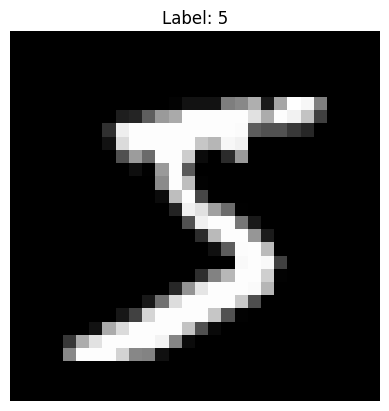

In [13]:
# Tar en rad med 784 pixlar och gör om den till en bild

plt.imshow(X[0].reshape(28,28), cmap="gray")
plt.title(f"Label: {y[0]}")
plt.axis("off")
plt.show()

Nu syns en bild med siffran 5 som exempel på hur det kan se ut

Eftersom vi har höga pixelvärden, upp till 255, behöver vi skala ner/normalisera (0-1) för att kunna köra ML-modeller.

Jag hade kunnat normalisera på detta sätt: 
pixelvärden till 0-1
X = X / 255.0

Istället för min-max normalisering (0-1) använder jag StandardScaler i pipeline, vilket ofta fungerar bra för ML-modellerna jag ska testa och undviker dataläckage.

## Nästa steg är att dela upp datan i tränings- och testdata. 

In [15]:
# genom att använda train_test_split() får jag en slumpmässig split som är mer statistisk korrekt än att ta de 60 000 första till träning och resterande till test

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=10000,
    random_state=42,
    stratify=y   # klassfördelningen blir liknande i både train och test
)

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


Nu är 60 000 bilder avsedda för träningsobservationer och 10 000 för testobservationer enligt MNIST-standard. 

(70000, 28, 28)


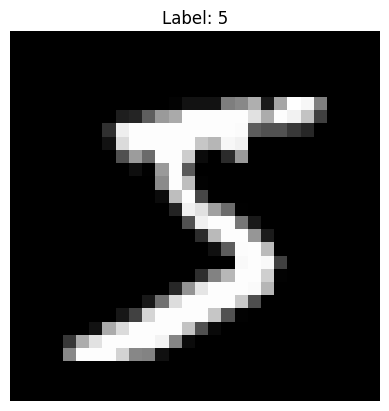

In [16]:
# Gör om hela datasetet till bildformat (utan att justera data)

X_img = X.reshape(-1, 28, 28)
print(X_img.shape)  # (70000, 28, 28)


plt.imshow(X_img[0], cmap="gray")
plt.title(f"Label: {y[0]}")
plt.axis("off")
plt.show()

In [17]:
X_img = X.reshape(-1, 28, 28)
X_crop = X_img[:, 4:24, 4:24]           # Blir nu 20x20
X_crop = X_crop.reshape(-1, 400)        # Med 400 features


Beskär bilderna så att ytterkanterna/ramen som inte innehåller någon siffra inte behöver analyseras. På så vis minskar antalet pixlar att analysera till 400 från 784.
Detta inkluderas sedan i Pipeline.

In [21]:
X_img = X.reshape(-1, 28, 28)

border = (
    X_img[:, :4, :].sum() + X_img[:, -4:, :].sum() +
    X_img[:, :, :4].sum() + X_img[:, :, -4:].sum()
)
center = X_img[:, 4:24, 4:24].sum()

print("Border sum:", border)
print("Center sum:", center)
print("Border share:", border / (border + center))


Border sum: 61036701
Center sum: 1771222676
Border share: 0.03331226013422662


In [22]:
class CenterCrop20x20(BaseEstimator, TransformerMixin):   # sklearn-kompatibel, kan användas i ML-modellernas pipeline ovh köras korrekt i varje CV-fold
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_img = X.reshape(-1, 28, 28)
        X_crop = X_img[:, 4:24, 4:24]   # 20x20 centrerat
        return X_crop.reshape(-1, 400)   # 400 features


Tittar på pixelvärde i kanterna jämfört med centrerat. 
Eftersom Border share är lågt tyder det på att det inte finns mycket i ytterkanterna och de kan tas bort för att få snabbare prediktioner.

## Dags att börja med ML-modellerna. Först ut är Logistisk Regression

Preprocessing integreras i en pipeline och används konsekvent för samtliga modeller för att få jämförbara resultat. 
Modellerna jämförs med hjälp av 5-fold cross-validation på träningsdatan. 

Cross-validation ger en stabil uppskattning när jag jämför modeller. Med GridSearchCV kan jag sedan justera/tuna hyperparametrar (t ex C) på träningsdatan utan dataläckage. Det kan vara värt att göra för att se hur stor förbättring det blir. Jag väljer att inte göra GridSearch i nuläget, utan bara på den/de modeller av störst intresse eller med störst potential.

Den modell som uppnår högst genomsnittlig accuracy eller som prestandamässigt är bäst kommer att utvärderas på testdatan och sedan tränas på hela datasetet (X och y).

In [20]:
pipe_lr = Pipeline(steps=[
    ("crop", CenterCrop20x20()),      # 28x28 blir 20x20 för att optimera tidsmässigt
    ("preprocess", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

cv_scores = cross_val_score(
    pipe_lr,   # Använder pipeline
    X_train,
    y_train,
    cv=5,   # 5-folds för att det ska vara bra utan att ta alldeles för lång tid
    scoring="accuracy",
    n_jobs=-1     # parallell körning = snabbare
)

print("Logistic Regression CV accuracy:", cv_scores.mean())
print("Std:", cv_scores.std())


Logistic Regression CV accuracy: 0.9109666666666666
Std: 0.0012775845264491098


När man utgår från den linjär baslinjen i Logistisk Regression, blir accuracy 91,09 % när de yttersta pixlarna inte analyseras (dvs 400 features kvar).

Jag fick en accuracy på 91,22 % när jag inte hade någon crop/beskärning. Den tid jag sparar är värt den lilla försämringen i prestanda.
Därför har jag valt att ta bort varianten där jag analyserar 784 features.

Nu ska vi se vad träningen med linjär SVC, som är bra för stora dataset, ger för resultat. Denna modell går snabbare att träna än SVC eftersom den endast gör en linjär gräns och inte har någon kernel-metod.

In [24]:
pipe_linearsvc = Pipeline(steps=[
    ("crop", CenterCrop20x20()),     #  crop
    ("preprocess", StandardScaler()),
    ("model", LinearSVC(dual="auto", max_iter=5000))
])

cv_scores_linearsvc = cross_val_score(
    pipe_linearsvc,
    X_train,
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1     # snabbare om flera kärnor körs
)

print("LinearSVC CV accuracy:", cv_scores_linearsvc.mean())
print("Std:", cv_scores_linearsvc.std())


LinearSVC CV accuracy: 0.9063000000000001
Std: 0.0016402913020422826


Accuracy på 90.63 % för LinearSVC med crop i preprocessing-pipeline. Även här gör jag avvägningen att försämringen i prestanda (91,31 -> 90,63) är så pass liten att den inte är avgörande, i jämförelse med den extra tid det tar att träna modellen. Det går snabbare att träna modellen och är bättre för prediktionen i appen sedan.

Nedan tränas vanlig SVC-modell med kernel RBF, som är standard. Här är StandarsScaler ofta avgörande eftersom modellen bygger på avstånd mellan datapunkter. Alla features får samma skala och RBF-kärnan fungerar korrekt.

In [25]:
pipe_svc_rbf = Pipeline(steps=[
    ("crop", CenterCrop20x20()),
    ("preprocess", StandardScaler()),
    ("model", SVC(kernel="rbf"))
])

cv_scores_svc_rbf = cross_val_score(
    pipe_svc_rbf,
    X_train,
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

print("SVC RBF CV accuracy:", cv_scores_svc_rbf.mean())
print("Std:", cv_scores_svc_rbf.std())


SVC RBF CV accuracy: 0.9763833333333333
Std: 0.0018845866036525719


SVC med RBF-kernel (beskuren till 20x20, dvs 400 features) resulterar i 97.63 % accuracy. Utan crop blir resultatet 97,77 %. Även här görs avvägningen att tidsbesparingen är av största vikt.

### Jag testade som jämförelse att ändra till SVC linear kernel, vilket gav en accuracy på 93,5 %. 
Det ger mig insikten att linear kernel är ett sämre alternativ. Dessuom tog den modellen längre tid att köra (nästan 2 timmar). Därför har jag valt att inte ha med den.

## GridSearch
Jag börjar att träna GridSearch på SVC med RBF-kernel, ställer in C och gamma på olika värden. Eftersom det tar otroligt lång tid att träna GridSearch på SVC med RBF-kernel, väljer jag att stoppa och istället försöka ställa in LinearSVC för att förbättra den något. Jag vill se om resultatet kommer upp i en godtagbar nivå, trade-off: tid vs. accuracy.

De linjära modellerna jag har använt tränades snabbare men gav något lägre accuracy. 
SVC med RBF-kärna gav högst precision men tog längre träningstid, vilket kräver en avvägning mellan accuracy och tid. 
Jag väljer därför att prova att finjustera LinearSVC-modellen, som var väldigt snabb att träna, med endast hyperparametern C (eftersom den har störst påverkan) för att se om accuracy ökar.

In [29]:
# Tunar endast C för LinearSVC (snabbare än större grid)
pipe_linearsvc_tune = Pipeline(steps=[
    ("crop", CenterCrop20x20()),
    ("preprocess", StandardScaler()),
    ("model", LinearSVC(dual=False, max_iter=8000, random_state=42))
])

param_grid = {"model__C": [0.1, 1, 3]}

gs = GridSearchCV(
    pipe_linearsvc_tune,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=1,      # svårt att slutföra steget annars
    verbose=1
)

gs.fit(X_train, y_train)

pipe_linearsvc_tuned = gs.best_estimator_
print("Best params:", gs.best_params_)
print("Best CV accuracy:", gs.best_score_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params: {'model__C': 1}
Best CV accuracy: 0.9063000000000001


Best CV: 90,63 %
Eftersom resultatet av finjusteringen på LinearSVC (utan kernel) inte gör någon skillnad, väljer jag att inte fortsätta finjustera den. 
Hittills är jag mest nöjd med SVC med RBF-kernel (utan tuning med GridSearch pga tidsåtgången och den höga accuracy den har ändå). Att den tar lite tid att träna är acceptabelt.

Jag ska testa RandomForest också och se hur bra den är för att kunna fastställa vilken modell jag ska använda till resterande steg med testdata, slutträning och till appen.

In [30]:
pipe_rf = Pipeline(steps=[
    ("crop", CenterCrop20x20()),
    ("preprocess", StandardScaler()),
    ("model", RandomForestClassifier(
        n_estimators=200,          # antal träd (kan ökas)
        random_state=42,
        n_jobs=-1
    ))
])

cv_scores_rf = cross_val_score(
    pipe_rf,
    X_train,
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

print("RandomForest CV accuracy:", cv_scores_rf.mean())
print("Std:", cv_scores_rf.std())


RandomForest CV accuracy: 0.9689
Std: 0.0014723375216905187


RandomForest gav en accuracy på 96,89 % och var väldigt snabb. Det tog inte ens 1 minut att träna modellen. 




# Jämförelse mellan modellerna: 

### Logistisk Regression (91,09 %) - lägre accuracy

### LinearSVC (90,63 %)            - lägre accuracy men snabb

### SVC, RBF-kernel (97,63 %)      - högst accuracy men tung och långsam

### SVC, linear kernel (93,5 %)    - lägre accuracy och otroligt långsam

### RandomForest (96,89 %)         - bra accuracy, snabb och stabil

Provar en liten finjustering på RandomForest för att se vad resultatet blir.

In [31]:
# StandardScaler används för linjära modeller och SVM, men är inte nödvändigt för RandomForest eftersom trädmodeller inte påverkas av feature-skalning

param_grid = {
    "model__n_estimators": [200, 300],
    "model__max_depth": [None, 20],
    "model__max_features": ["sqrt", "log2"]
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

gs_rf.fit(X_train, y_train)

print("Best params:", gs_rf.best_params_)
print("Best CV accuracy:", gs_rf.best_score_)

rf_tuned_model = gs_rf.best_estimator_


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__n_estimators': 300}
Best CV accuracy: 0.9693666666666667


Accuracy ökar väldigt lite, till 96,93 %. 
Resultatet visar att 300 träd och obegränsat maxdjup gav bäst prestanda.
Förbättringen i accuracy är liten men bekräftar att modellen redan presterar väl med standardinställningar.
## Den optimerade RandomForest-modellen väljs som slutmodell.
### Den ger jämna, tillförlitliga resultat, är mindre känslig för små förändringar i datan och har låg risk för överanpassning tack vare att många beslutsträd kombineras.

In [32]:
# Slututvärdera på testdata (körs bara en gång)

y_pred = rf_tuned_model.predict(X_test)

print("\n=== Slututvärdering på testdata ===")
print("Final test accuracy:", accuracy_score(y_test, y_pred))



=== Slututvärdering på testdata ===
Final test accuracy: 0.9669


## Utvärdering av resultatet, accuracy på testdatan, blir: 96,69 % accuracy

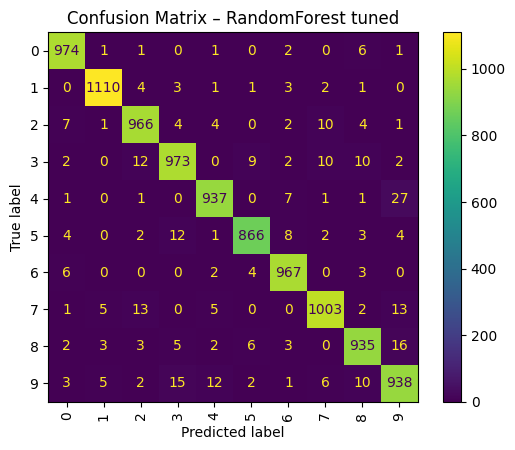


Classification report (precision/recall/F1):

              precision    recall  f1-score   support

           0     0.9740    0.9878    0.9809       986
           1     0.9867    0.9867    0.9867      1125
           2     0.9622    0.9670    0.9646       999
           3     0.9615    0.9539    0.9577      1020
           4     0.9710    0.9610    0.9660       975
           5     0.9752    0.9601    0.9676       902
           6     0.9719    0.9847    0.9782       982
           7     0.9700    0.9626    0.9663      1042
           8     0.9590    0.9590    0.9590       975
           9     0.9361    0.9437    0.9399       994

    accuracy                         0.9669     10000
   macro avg     0.9667    0.9666    0.9667     10000
weighted avg     0.9669    0.9669    0.9669     10000



In [33]:
# Confusion matrix och report
labels = list(range(10))
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format="d", xticks_rotation="vertical")
plt.title("Confusion Matrix – RandomForest tuned")
plt.show()

# Precision / Recall / F1-score
print("\nClassification report (precision/recall/F1):\n")
print(classification_report(y_test, y_pred, digits=4))

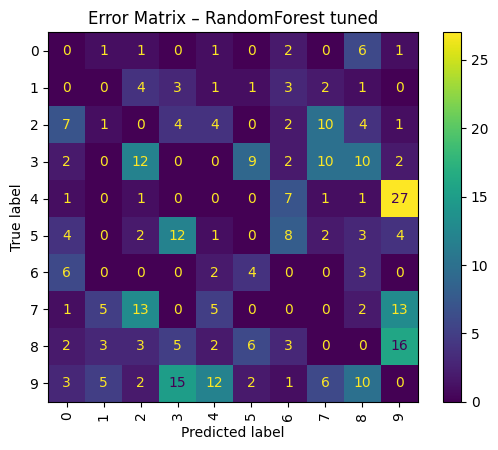

In [34]:
# Skapar error matrix = bara felklassificeringar
error_matrix = cm.copy()
np.fill_diagonal(error_matrix, 0)

disp_err = ConfusionMatrixDisplay(confusion_matrix=error_matrix, display_labels=labels)
disp_err.plot(values_format="d", xticks_rotation="vertical")
plt.title("Error Matrix – RandomForest tuned")
plt.show()

Confusion matrix visar att modellen presterar mycket bra, då majoriteten av observationerna ligger på diagonalen vilket innebär korrekta klassificeringar.  

De vanligaste felen sker mellan visuellt liknande siffror. Exempelvis förväxlas 4 ibland med 9, och 3 och 5 kan vara svåra att särskilja beroende på handstil. Siffran 8 kan även ibland tolkas som 9.  

Siffran 0 har mycket få felklassificeringar, vilket tyder på att den är lätt att identifiera.  

Precision, recall och F1-score ligger genomgående högt för samtliga klasser, vilket indikerar att modellen generaliserar väl till ny data.  

Error matrixen gör det möjligt att identifiera vilka siffror som är svårast att klassificera och kan användas som underlag för framtida förbättringar av modellen.

In [ ]:
# Slutlig modell

# Efter att modellen utvärderats på testdata tränas den om på hela datasetet för att använda all data i den modell som sparas till Streamlit-appen.

rf_tuned_model.fit(X, y)   # hela datasetet

import joblib
joblib.dump(rf_tuned_model, "mnist_model.joblib")

print("Slutlig modell (RandomForest tuned) tränad på hela datasetet och sparad som mnist_model.joblib")


Slutlig modell (RandomForest tuned) tränad på hela datasetet och sparad som mnist_model.joblib


# Slutsats

Modellerna jämfördes främst med hjälp av accuracy, vilket är ett lämpligt mått eftersom MNIST-datasetet är relativt balanserat mellan klasserna. Accuracy ger därmed en rättvis bild av modellernas övergripande prestanda.

För att få en mer nyanserad utvärdering analyserades även precision, recall och F1-score per klass med hjälp av classification report och confusion matrix. Dessa mått visar hur väl modellen klassificerar varje enskild siffra och vilka siffror som är svårare att särskilja, exempelvis visuellt liknande siffror.

## Den högsta accuracy-nivån uppnåddes av SVC med RBF-kernel. Denna modell visade sig dock vara resurskrävande och betydligt långsammare att träna och använda, vilket gör den mindre lämplig för en interaktiv applikation.

## RandomForestClassifier (tuned) valdes som slutmodell. Den ger mycket hög accuracy samtidigt som den är stabil, snabb att träna och mindre känslig för små variationer i datan. Modellen ger konsekventa resultat och generaliserar väl till ny data enligt testutvärderingen.